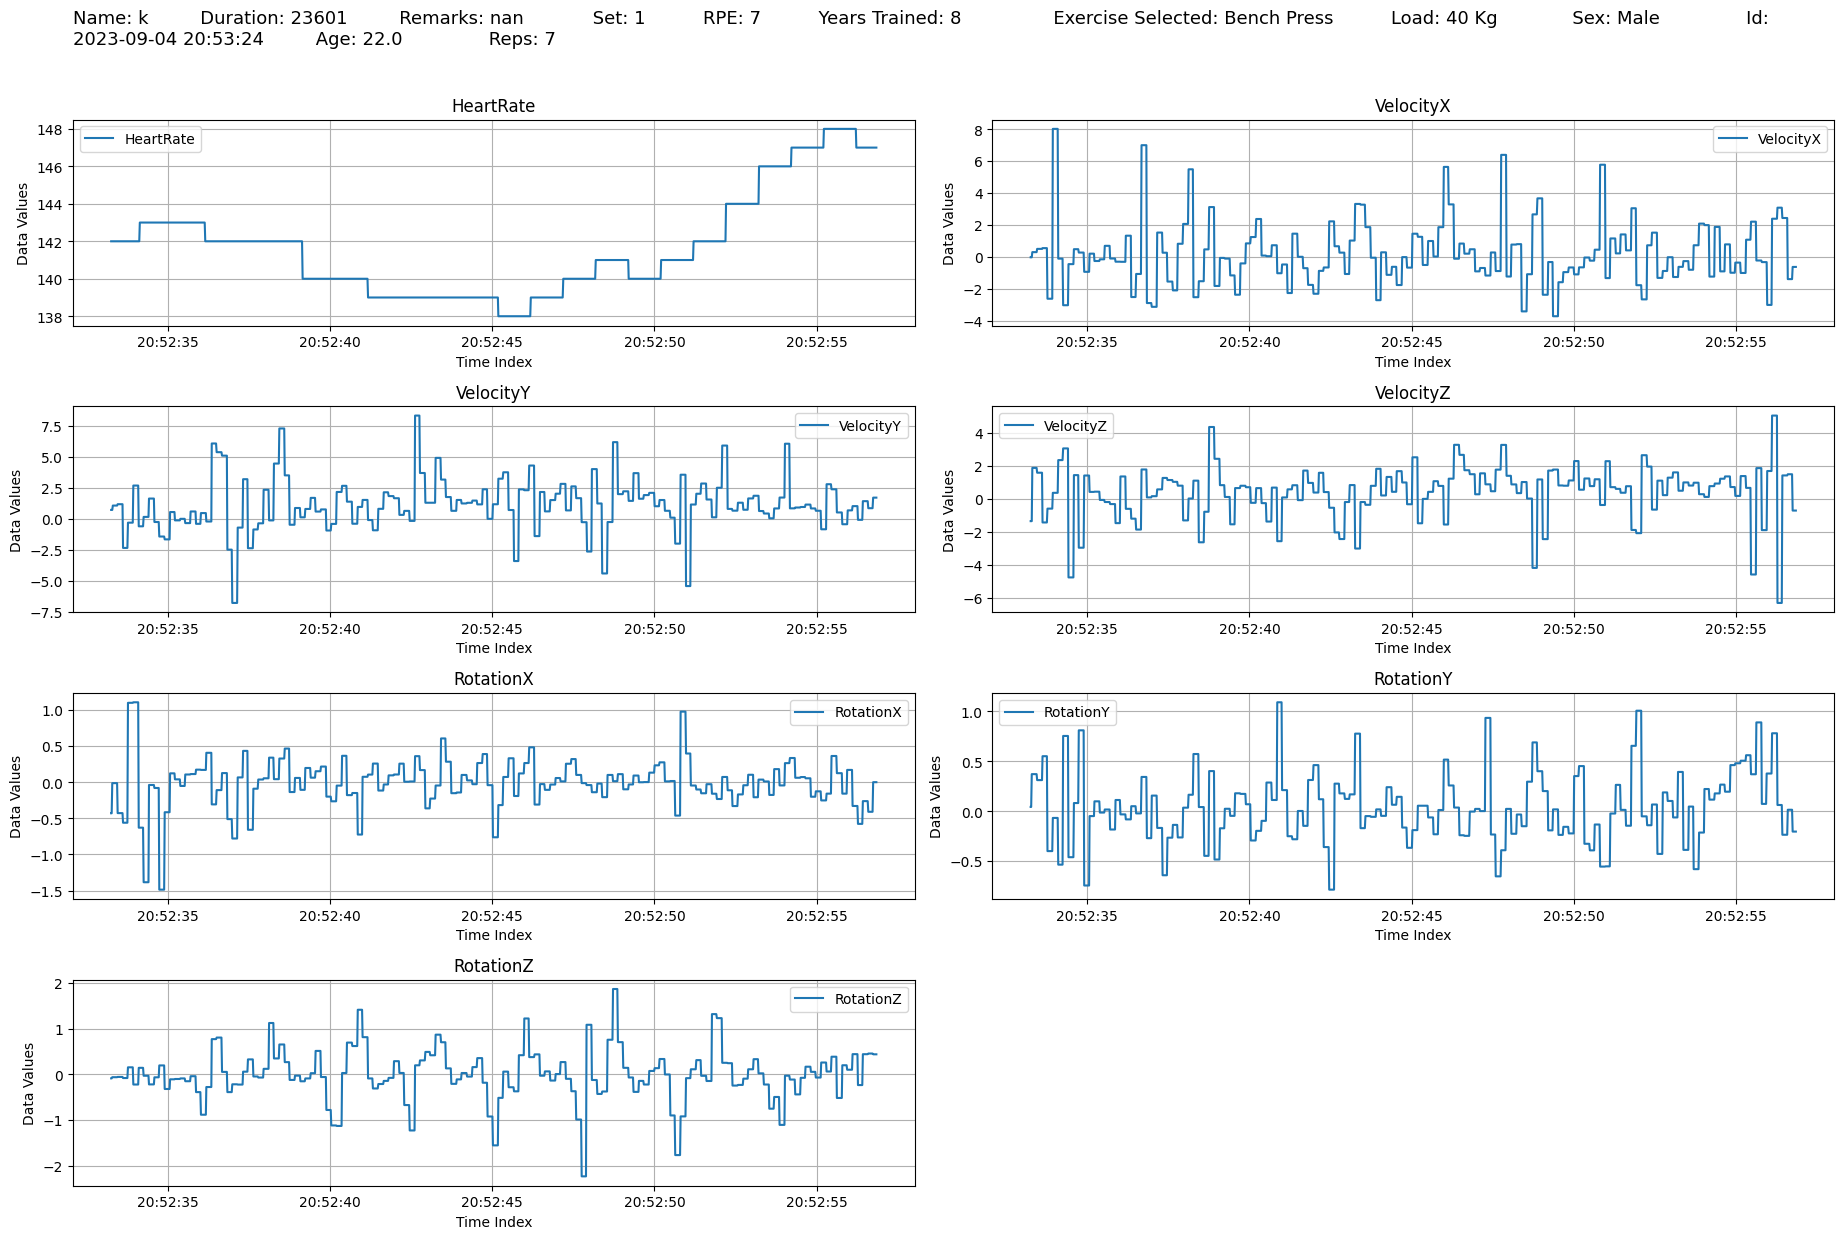

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.gridspec as gridspec
import textwrap

def load_data(file_path, column_time, record_index):
    df = pd.read_csv(file_path)
    
    # Remove rows where TimeIndice is NaN
    df = df[df[column_time].notna()]
    
    series_time = df[column_time].iloc[record_index]
    timestamps = [datetime.strptime(x.strip(), '%H:%M:%S.%f') for x in series_time.split(';') if x.strip()]

    return df, timestamps

def plot_data(df, timestamps, columns, record_index):
    n = len(columns)
    n_rows = (n + 1) // 2
    
    gs = gridspec.GridSpec(n_rows + 1, 2, height_ratios=[0.1] + [1]*n_rows)
    fig = plt.figure(figsize=(20, 2.5 * (n_rows + 1)))
    
    ax_text = fig.add_subplot(gs[0, :])
    ax_text.axis('off')
    
    all_columns = set(df.columns)
    plottable_columns = set(columns + [column_time])
    info_columns = list(all_columns - plottable_columns)
    
    if info_columns:
        info_text = "\t\t".join([f"{col}: {df[col].iloc[record_index]}" for col in info_columns])
        wrapped_text = textwrap.fill(info_text, width=220)
        ax_text.text(0, 0.5, wrapped_text, ha='left', va='center', fontsize=13)
    
    axs = [fig.add_subplot(gs[i+1, j]) for i in range(n_rows) for j in range(2)]
    
    for idx, ax in enumerate(axs[:n]):
        column = columns[idx]
        series_data = df[column].iloc[record_index]
        data_values = [float(x.strip()) for x in series_data.split(';') if x.strip()]

        ax.plot(timestamps, data_values, label=column)
        ax.set_title(column)
        ax.set_xlabel('Time Index')
        ax.set_ylabel('Data Values')
        ax.grid(True)
        ax.legend()
        
    if n % 2 != 0:
        axs[-1].axis('off')
        
    plt.tight_layout()
    plt.show()

file_path = "./sep5.csv"
column_time = 'TimeIndice'
record_index = -1  # make sure this index is still valid after filtering NaN
time_series_columns = ['HeartRate', 'VelocityX', 'VelocityY', 'VelocityZ', 'RotationX', 'RotationY', 'RotationZ']

df, timestamps = load_data(file_path, column_time, record_index)
plot_data(df, timestamps, time_series_columns, record_index)

In [35]:
df.loc[:,['Set', 'Name', 'Exercise Selected', 'Load', 'Reps', 'RPE', 'Remarks', 'Duration']]

,Set,Name,Exercise Selected,Load,Reps,RPE,Remarks,Duration
0,1,Kalki Lamadrid,Deadlift,21 Kg,12,3-4,NaN,47658
1,1,Kalki,Back Rows,21 Lb,10,5-6,NaN,43633
2,1,Kalki,Bicep Curl,21 Kg,12,7,NaN,50726
3,1,Kalki,Back Rows,34 Kg,12,7.5,NaN,37730
4,2,Kalki,Back Rows,34 Kg,12,7.5,NaN,44728
...,...,...,...,...,...,...,...,...
74,1,k,Squat,20 Kg,16,7.5,NaN,39196
75,1,b,Squat,10 Kg,21,9,NaN,46377
76,1,r,Squat,10 Kg,15,10,NaN,32792
77,1,a,Squat,20 Kg,9,10,NaN,18769


In [36]:
df

,Set,TimeIndice,HeartRate,VelocityX,VelocityY,VelocityZ,RotationX,RotationY,RotationZ,Id,Exercise Selected,Load,Reps,Name,Sex,Years Trained,Age,RPE,Duration,Remarks
0,1,22:07:05.296;22:07:05.316;22:07:05.330;22:07:0...,120.0;120.0;120.0;120.0;120.0;120.0;120.0;120....,0.15083;0.15083;0.15083;0.15083;0.15083;0.1508...,0.00958;0.00958;0.00958;0.00958;0.00958;0.0095...,0.04549;0.04549;0.04549;0.04549;0.04549;0.0454...,0.09163;0.09163;0.09163;0.09163;0.09163;0.0916...,0.00733;0.00733;0.00733;0.00733;0.00733;0.0073...,-0.05498;-0.05498;-0.05498;-0.05498;-0.05498;-...,2023-09-01 22:08:52,Deadlift,21 Kg,12,Kalki Lamadrid,Male,5,22.0,3-4,47658,NaN
1,1,22:11:20.786;22:11:20.801;22:11:20.820;22:11:2...,103.0;103.0;103.0;103.0;103.0;103.0;103.0;103....,-0.23463;-0.23463;-0.23463;-0.23463;-0.23463;-...,-0.13168;-0.13168;-0.13168;-0.13168;-0.13168;-...,-0.03591;-0.03591;-0.03591;-0.03591;-0.03591;-...,-0.09774;-0.09774;-0.09774;-0.09774;-0.09774;-...,-0.01833;-0.01833;-0.01833;-0.01833;-0.01833;-...,-0.06231;-0.06231;-0.06231;-0.06231;-0.06231;-...,2023-09-01 22:12:42,Back Rows,21 Lb,10,Kalki,Male,5,22.0,5-6,43633,NaN
2,1,22:17:15.742;22:17:15.758;22:17:15.775;22:17:1...,98.0;98.0;98.0;99.0;99.0;99.0;99.0;99.0;99.0;9...,0.26097;0.26097;0.26097;0.26097;0.26097;0.2609...,0.0407;0.0407;0.0407;0.0407;0.0407;0.0407;0.04...,-0.10295;-0.10295;-0.10295;-0.10295;-0.10295;-...,-0.281;-0.281;-0.281;-0.281;-0.281;-0.281;-0.2...,-0.03176;-0.03176;-0.03176;-0.03176;-0.03176;-...,-0.0281;-0.0281;-0.0281;-0.0281;-0.0281;-0.028...,2023-09-01 22:18:58,Bicep Curl,21 Kg,12,Kalki,Male,5,22.0,7,50726,NaN
3,1,22:24:51.415;22:24:51.432;22:24:51.449;22:24:5...,92.0;92.0;92.0;92.0;92.0;92.0;92.0;92.0;92.0;9...,0.06704;0.06704;0.06704;0.06704;0.06704;0.0670...,0.18196;0.18196;0.18196;0.18196;0.18196;0.1819...,0.0407;0.0407;0.0407;0.0407;0.0407;0.0407;0.04...,0.0672;0.0672;0.0672;0.0672;0.0672;0.0672;0.06...,0.03299;0.03299;0.03299;0.03299;0.03299;0.0329...,0.02688;0.02688;0.02688;0.02688;0.02688;0.0268...,2023-09-01 22:26:58,Back Rows,34 Kg,12,Kalki,Male,5,22.0,7.5,37730,NaN
4,2,22:28:35.257;22:28:35.273;22:28:35.290;22:28:3...,94.0;94.0;94.0;94.0;94.0;94.0;94.0;94.0;94.0;9...,0.08619;0.08619;0.08619;0.08619;0.08619;0.0861...,-0.31603;-0.31603;-0.31603;-0.31603;-0.31603;-...,0.24181;0.24181;0.24181;0.24181;0.24181;0.2418...,-0.14416;-0.14416;-0.14416;-0.14416;-0.14416;-...,0.04276;0.04276;0.04276;0.04276;0.04276;0.0427...,-0.13317;-0.13317;-0.13317;-0.13317;-0.13317;-...,2023-09-01 22:29:36,Back Rows,34 Kg,12,Kalki,Male,5,22.0,7.5,44728,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,1,20:42:24.433;20:42:24.453;20:42:24.467;20:42:2...,104.0;104.0;104.0;104.0;104.0;104.0;104.0;104....,-0.56503;-0.56503;-0.56503;-0.56503;-0.56503;-...,-0.24181;-0.24181;-0.24181;-0.24181;-0.24181;-...,0.54348;0.54348;0.54348;0.54348;0.54348;0.5434...,-0.05498;-0.05498;-0.05498;-0.05498;-0.05498;-...,0.09529;0.09529;0.09529;0.09529;0.09529;0.0952...,0.21625;0.21625;0.21625;0.21625;0.21625;0.2162...,2023-09-04 20:43:25,Squat,20 Kg,16,k,Male,8,22.0,7.5,39196,NaN
75,1,20:43:43.874;20:43:43.892;20:43:43.907;20:43:4...,111.0;111.0;111.0;111.0;111.0;111.0;111.0;111....,0.30406;0.30406;0.30406;0.30406;0.30406;1.1516...,-0.2897;-0.2897;-0.2897;-0.2897;-0.2897;0.4189...,-0.81403;-0.81403;-0.81403;-0.81403;-0.81403;-...,-0.18448;-0.18448;-0.18448;-0.18448;-0.18448;0...,0.70494;0.70494;0.70494;0.70494;0.70494;0.4520...,0.25412;0.25412;0.25412;0.25412;0.25412;0.1050...,2023-09-04 20:44:49,Squat,10 Kg,21,b,Male,3,22.0,9,46377,NaN
76,1,20:44:56.947;20:44:56.965;20:44:56.983;20:44:5...,109.0;109.0;109.0;109.0;109.0;109.0;109.0;109....,-2.54264;-2.54264;-2.54264;-2.54264;-2.54264;-...,-1.32639;-1.32639;-1.32639;-1.32639;-1.32639;-...,-1.58496;-1.58496;-1.58496;-1.58496;-1.58496;-...,-0.30421;-0.30421;-0.30421;-0.30421;-0.30421;-...,0.34819;0.34819;0.34819;0.34819;0.34819;0.3481...,0.00367;0.00367;0.00367;0.00367;0.00367;0.0036...,2023-09-04 20:45:45,Squat,10 K

In [37]:
filtered_df = df[df['Duration'] < 15000]

# Display the filtered DataFrame
print(filtered_df)

    Set                                         TimeIndice  \
29    2  09:27:26.014;09:27:26.034;09:27:26.048;09:27:2...   
51    1  19:45:04.588;19:45:04.600;19:45:04.614;19:45:0...   

                                            HeartRate  \
29  141.0;141.0;141.0;141.0;141.0;141.0;141.0;141....   
51  137.0;137.0;137.0;137.0;137.0;137.0;137.0;137....   

                                            VelocityX  \
29  -0.81163;-0.81163;-0.81163;-0.81163;-0.81163;-...   
51  1.74537;1.74537;1.74537;1.74537;1.74537;1.7453...   

                                            VelocityY  \
29  -0.59137;-0.59137;-0.59137;-0.59137;-0.59137;-...   
51  -1.1133;-1.1133;-1.1133;-1.1133;-1.1133;-1.113...   

                                            VelocityZ  \
29  -0.23703;-0.23703;-0.23703;-0.23703;-0.23703;-...   
51  0.07183;0.07183;0.07183;0.07183;0.07183;0.0718...   

                                            RotationX  \
29  -0.18448;-0.18448;-0.18448;-0.18448;-0.18448;-...   
51  0.23213